In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from typing import Dict, Tuple, List, Union

# Define the 5 channels used in the POSH panel
IF_CHANNELS = ["Nuclear_Stain", "ER_ConA", "Golgi_WGA", "Actin_Phalloidin", "Mito_Probe"]
N_CHANNELS = len(IF_CHANNELS)

# --- Statistical Model Parameters (Should ideally be loaded from a config/modeling file) ---
MU_I_NTC = np.array([1000, 500, 800, 600, 950])
SIGMA_I_NTC = np.diag([200**2, 100**2, 150**2, 120**2, 180**2])
MU_I_KO = np.array([850, 600, 800, 800, 950]) # Modeled phenotypic shift
SIGMA_I_KO = 1.5 * SIGMA_I_NTC 

# --- Feature Extraction Matrix (A) ---
np.random.seed(43) 
FEATURE_MATRIX_A = np.random.randn(N_CHANNELS, N_CHANNELS) * 0.5 

# --- DINO Encoder Weights (W and B) ---
EMBEDDING_DIM = 128
np.random.seed(42) 
DINO_ENCODER_W = np.random.randn(EMBEDDING_DIM, N_CHANNELS) * 0.1
DINO_ENCODER_B = np.random.randn(EMBEDDING_DIM) * 0.01

# --- Core DINO Encoder Function ---
def DINO_ENCODER_F(raw_features: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Simulates the DINO non-linear transformation: W * tanh(X) + b"""
    tanh_X = np.tanh(raw_features)
    # X @ W.T is used since X is (N, 5) and W is (128, 5).
    return tanh_X @ W.T + b

# ====================================================================================
# PoshAnalysisSimulator Class (Copied from src/simulation/analysis_simulator.py)
# ====================================================================================
class PoshAnalysisSimulator:
    
    def __init__(self, embedding_dim: int = EMBEDDING_DIM):
        self.embedding_dim = embedding_dim
        self.if_dim = N_CHANNELS
        
        self.mu_i_ntc = MU_I_NTC
        self.sigma_i_ntc = SIGMA_I_NTC
        self.mu_i_ko = MU_I_KO
        self.sigma_i_ko = SIGMA_I_KO
        
        self.feature_matrix_A = FEATURE_MATRIX_A
        self.raw_feature_dim = self.feature_matrix_A.shape[0]

        self.W = DINO_ENCODER_W
        self.b = DINO_ENCODER_B

    def simulate_if_intensity_by_well(self, n_wells_ntc: int = 10, n_wells_ko: int = 10, n_cells_per_well: int = 250) -> pd.DataFrame:
        print(f"-> Simulating IF data for {n_wells_ntc} NTC and {n_wells_ko} KO wells...")
        all_data = []
        for i in range(n_wells_ntc):
            I_NTC_well = np.random.multivariate_normal(mean=self.mu_i_ntc, cov=self.sigma_i_ntc, size=n_cells_per_well)
            df_well = pd.DataFrame(I_NTC_well, columns=[f"Intensity_{ch}" for ch in IF_CHANNELS])
            df_well['Condition'], df_well['Well'] = 'NTC', f"A{i+1:02d}"
            all_data.append(df_well)

        for i in range(n_wells_ko):
            I_KO_well = np.random.multivariate_normal(mean=self.mu_i_ko, cov=self.sigma_i_ko, size=n_cells_per_well)
            df_well = pd.DataFrame(I_KO_well, columns=[f"Intensity_{ch}" for ch in IF_CHANNELS])
            df_well['Condition'], df_well['Well'] = 'KO', f"B{i+1:02d}"
            all_data.append(df_well)
            
        df_final = pd.concat(all_data, ignore_index=True)
        intensity_cols = [f"Intensity_{ch}" for ch in IF_CHANNELS]
        df_final[intensity_cols] = df_final[intensity_cols].clip(lower=1)
        print(f"-> Generated {len(df_final)} single-cell IF records.")
        return df_final

    def extract_features(self, I_NTC: np.ndarray, I_KO: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print("-> Applying feature extraction g(I) to get 5D morphological features...")
        X_NTC = np.log(I_NTC) @ self.feature_matrix_A.T 
        X_KO = np.log(I_KO) @ self.feature_matrix_A.T
        return X_NTC, X_KO

    def generate_embeddings(self, X_NTC: np.ndarray, X_KO: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print("-> Applying DINO encoder f(X) to generate 128D embeddings...")
        E_NTC = DINO_ENCODER_F(X_NTC, self.W, self.b)
        E_KO = DINO_ENCODER_F(X_KO, self.W, self.b)
        return E_NTC, E_KO

    def infer_phenotype_shift(self, E_NTC: np.ndarray, E_KO: np.ndarray) -> Dict[str, Union[float, np.ndarray]]:
        print("-> Calculating Effect Size (Mahalanobis D_M)...")
        N_NTC, _ = E_NTC.shape
        N_KO, _ = E_KO.shape
        c_ntc = np.mean(E_NTC, axis=0)
        c_ko = np.mean(E_KO, axis=0)
        delta_e = c_ko - c_ntc
        S_NTC = np.cov(E_NTC, rowvar=False)
        S_KO = np.cov(E_KO, rowvar=False)
        S_pooled = ( (N_NTC - 1) * S_NTC + (N_KO - 1) * S_KO ) / (N_NTC + N_KO - 2)
        try:
            S_pooled_inv_dot_delta_e = np.linalg.solve(S_pooled, delta_e)
            D_M = np.sqrt(delta_e.T @ S_pooled_inv_dot_delta_e)
        except np.linalg.LinAlgError:
            D_M = np.nan
        results = {"delta_e_magnitude": np.linalg.norm(delta_e), "D_M": D_M}
        return results

# ====================================================================================

In [2]:
# --- Configuration ---
N_WELLS = 20 # Total number of wells (10 NTC, 10 KO)
CELLS_PER_WELL = 500
TOTAL_CELLS = N_WELLS * CELLS_PER_WELL

simulator = PoshAnalysisSimulator(embedding_dim=128)

# --- 1. Simulate IF Intensity Data (I) ---
df_I = simulator.simulate_if_intensity_by_well(
    n_wells_ntc=N_WELLS // 2, 
    n_wells_ko=N_WELLS // 2, 
    n_cells_per_well=CELLS_PER_WELL
)
I_NTC = df_I[df_I['Condition'] == 'NTC'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].values
I_KO = df_I[df_I['Condition'] == 'KO'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].values

# --- 2. Extract Morphological Features (X) ---
X_NTC, X_KO = simulator.extract_features(I_NTC, I_KO)

# --- 3. Generate DINO Embeddings (E) ---
E_NTC, E_KO = simulator.generate_embeddings(X_NTC, X_KO)

# Combine for visualization
df_E = pd.DataFrame(np.vstack([E_NTC, E_KO]))
df_E['Condition'] = ['NTC'] * E_NTC.shape[0] + ['KO'] * E_KO.shape[0]

# --- 4. Infer Phenotype Shift (Calculate D_M) ---
analysis_results = simulator.infer_phenotype_shift(E_NTC, E_KO)
D_M = analysis_results['D_M']

print("\n--- Summary of Results ---")
print(f"Total Cells Simulated: {TOTAL_CELLS}")
print(f"Raw Shift Magnitude (Euclidean Dist): {analysis_results['delta_e_magnitude']:.4f}")
print(f"Final Phenotypic Effect Size (Mahalanobis $D_M$): {D_M:.4f}")
print("--------------------------")

-> Simulating IF data for 10 NTC and 10 KO wells...
-> Generated 10000 single-cell IF records.
-> Applying feature extraction g(I) to get 5D morphological features...
-> Applying DINO encoder f(X) to generate 128D embeddings...
-> Calculating Effect Size (Mahalanobis D_M)...

--- Summary of Results ---
Total Cells Simulated: 10000
Raw Shift Magnitude (Euclidean Dist): 0.0125
Final Phenotypic Effect Size (Mahalanobis $D_M$): 1.3120
--------------------------


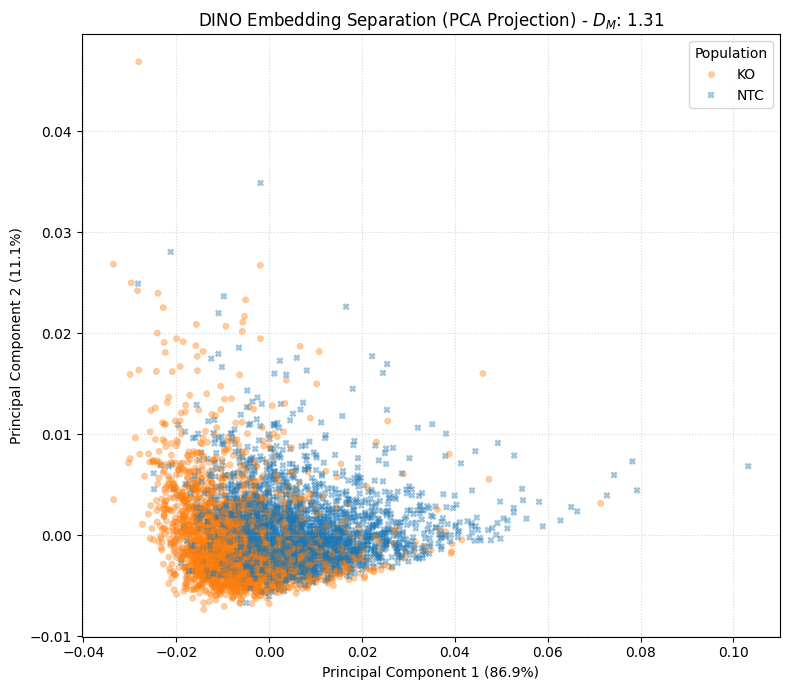

In [3]:
# --- DINO Embedding Separation (High-Dimensional Phenotype) ---
pca = PCA(n_components=2)
E_pca = pca.fit_transform(df_E.drop(columns='Condition').values) 

df_pca = pd.DataFrame(E_pca, columns=['PC1', 'PC2'])
df_pca['Condition'] = df_E['Condition']

plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=df_pca.sample(5000), # Sample points for cleaner visualization
    x='PC1', 
    y='PC2', 
    hue='Condition', 
    style='Condition',
    palette={'NTC': '#1f77b4', 'KO': '#ff7f0e'},
    s=20, 
    alpha=0.4, 
    edgecolor=None
)
plt.title(f'DINO Embedding Separation (PCA Projection) - $D_M$: {D_M:.2f}')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Population', loc='upper right')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [4]:
# --- Image Visualization Helper Function ---
from typing import List, Dict

def simulate_basic_image(intensity_vector: np.ndarray, channels: List[str]) -> Dict[str, np.ndarray]:
    """
    Simulates a basic 32x32 pixel synthetic image based on mean intensity.
    Uses basic shapes (masks) to represent cell morphology and intensity to 
    set pixel values.
    """
    SIZE = 32
    center = SIZE // 2
    y, x = np.ogrid[0:SIZE, 0:SIZE]
    dist_sq = (x - center)**2 + (y - center)**2
    
    # Define simple masks (simulating segmentation)
    nucleus_mask = dist_sq < (SIZE * 0.3)**2
    cell_mask = dist_sq < (SIZE * 0.45)**2
    
    simulated_images = {}
    
    for i, channel_name in enumerate(channels):
        I_c = intensity_vector[i]  # Mean intensity for this cell/channel

        img = np.zeros((SIZE, SIZE), dtype=np.float32)
        
        # Apply structured intensity proportional to the mean I_c
        if 'Nuclear' in channel_name:
            # Nuclear stain highlights the nucleus
            img[nucleus_mask] = I_c 
        elif 'Actin' in channel_name:
            # Cytoskeletal stain highlights the whole cell body
            img[cell_mask] = I_c * 0.8
        else: 
            # General organelle stain (ER, Golgi, Mito)
            img[cell_mask] = I_c * 0.7
            
        # Add basic Gaussian noise (simulating sensor/biological noise)
        img += np.random.randn(SIZE, SIZE) * (I_c * 0.03) 
        
        # Normalize the image data to a 0-1 range for plotting
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        simulated_images[channel_name] = img
        
    return simulated_images

In [6]:
import sys
!{sys.executable} -m pip install scikit-image

  Using cached scikit_image-0.25.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (14 kB)
  Using cached networkx-3.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.25.2-cp311-cp311-macosx_12_0_arm64.whl (13.2 MB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.6-py3-none-any.whl (2.1 MB)
Using cached tifffile-2025.10.16-py3-none-any.whl (231 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-image] [scikit-image]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import draw # For more complex shapes

def generate_realistic_cell_image(size: int = 128, 
                                  nuclear_intensity: float = 1.0, 
                                  wga_intensity: float = 1.0) -> Dict[str, np.ndarray]:
    """
    Generates a more realistic 128x128 pixel image of a single cell 
    with a nucleus and WGA (Golgi/Membrane) stain.
    
    Args:
        size (int): The dimension of the square image (e.g., 128).
        nuclear_intensity (float): Relative brightness of the nucleus (0-1).
        wga_intensity (float): Relative brightness of the WGA stain (0-1).
        
    Returns:
        Dict[str, np.ndarray]: A dictionary containing grayscale NumPy arrays
                                for 'nucleus' and 'wga' channels.
    """
    
    # Initialize blank grayscale images for each channel
    nucleus_channel = np.zeros((size, size), dtype=np.float32)
    wga_channel = np.zeros((size, size), dtype=np.float32)

    center_x, center_y = size // 2, size // 2

    # --- 1. Define Cell and Nucleus Morphology (Irregular Shapes) ---
    # Use skimage.draw to create more irregular, blob-like shapes
    
    # Generate an irregular cell body shape
    # Start with a large circle and perturb its points
    rr, cc = draw.circle_perimeter_aa(center_y, center_x, int(size * 0.4))
    cell_perimeter = np.vstack([rr, cc]).T
    
    # Add some random perturbation to the cell perimeter points
    perturbation_strength = int(size * 0.05)
    perturbed_perimeter = cell_perimeter + np.random.randint(-perturbation_strength, perturbation_strength, cell_perimeter.shape)
    
    # Ensure points stay within bounds
    perturbed_perimeter = np.clip(perturbed_perimeter, 0, size - 1)
    
    # Create filled polygon for the cell body
    rr_cell, cc_cell = draw.polygon(perturbed_perimeter[:, 0], perturbed_perimeter[:, 1], shape=(size, size))
    cell_mask = np.zeros((size, size), dtype=bool)
    cell_mask[rr_cell, cc_cell] = True
    
    # Generate a more irregular nucleus shape within the cell body
    # Position slightly off-center
    nucleus_center_y = center_y + np.random.randint(-int(size*0.05), int(size*0.05))
    nucleus_center_x = center_x + np.random.randint(-int(size*0.05), int(size*0.05))
    
    # Start with a smaller circle and perturb its points
    rr_nuc, cc_nuc = draw.circle_perimeter_aa(nucleus_center_y, nucleus_center_x, int(size * 0.15))
    nuc_perimeter = np.vstack([rr_nuc, cc_nuc]).T
    perturbed_nuc_perimeter = nuc_perimeter + np.random.randint(-int(size*0.03), int(size*0.03), nuc_perimeter.shape)
    perturbed_nuc_perimeter = np.clip(perturbed_nuc_perimeter, 0, size - 1)
    
    rr_nuc_fill, cc_nuc_fill = draw.polygon(perturbed_nuc_perimeter[:, 0], perturbed_nuc_perimeter[:, 1], shape=(size, size))
    nucleus_mask = np.zeros((size, size), dtype=bool)
    nucleus_mask[rr_nuc_fill, cc_nuc_fill] = True
    
    # Ensure nucleus is within the cell body (optional, but good practice)
    nucleus_mask = nucleus_mask & cell_mask


    # --- 2. Populate Channels with Intensities, Gradients, and Texture ---

    # Nucleus Channel (DAPI/Hoechst - White)
    # Apply base intensity, add some gradient/texture
    nucleus_channel[nucleus_mask] = nuclear_intensity * (0.8 + 0.2 * np.random.rand(nucleus_mask.sum()))
    nucleus_channel = gaussian_filter(nucleus_channel, sigma=1) # Smooth edges
    
    # WGA Channel (Golgi/Membrane - Green)
    # WGA often stains the Golgi (perinuclear) and plasma membrane.
    # Simulate a perinuclear ring and some speckled membrane staining.
    
    # Perinuclear Golgi
    perinuclear_mask = cell_mask & ~nucleus_mask
    dist_from_nucleus_edge = gaussian_filter(nucleus_mask.astype(float), sigma=5) # Blur nucleus for distance
    wga_channel[perinuclear_mask] = wga_intensity * (0.6 + 0.4 * dist_from_nucleus_edge[perinuclear_mask])
    
    # Add some general membrane staining (random spots near cell edge)
    membrane_dots_mask = np.random.rand(size, size) < 0.005 # Sparse dots
    membrane_dots_mask = membrane_dots_mask & cell_mask & ~nucleus_mask
    wga_channel[membrane_dots_mask] += wga_intensity * 0.5 * np.random.rand(membrane_dots_mask.sum())
    
    wga_channel = gaussian_filter(wga_channel, sigma=1.5) # Smooth and blur WGA slightly
    
    # --- 3. Add General Background Noise ---
    background_noise = np.random.rand(size, size) * 0.05
    nucleus_channel += background_noise
    wga_channel += background_noise
    
    # --- 4. Normalize Channels to 0-1 range ---
    nucleus_channel = np.clip(nucleus_channel / nucleus_channel.max(), 0, 1)
    wga_channel = np.clip(wga_channel / wga_channel.max(), 0, 1)

    return {'nucleus': nucleus_channel, 'wga': wga_channel}


# ------------------------------------------------------------------------
# Example Usage in your Notebook
# ------------------------------------------------------------------------

if __name__ == '__main__':
    # Generate the more realistic single-cell channels
    cell_channels = generate_realistic_cell_image(size=128, 
                                                  nuclear_intensity=1.0, 
                                                  wga_intensity=0.8) # Example intensities
    
    # --- Combine channels for display ---
    # Create an empty RGB image
    rgb_image = np.zeros((128, 128, 3), dtype=np.float32)

    # Assign channels to colors:
    # Nucleus -> Blue channel (DAPI/Hoechst is typically blue)
    # WGA     -> Green channel (often Alexa488/FITC, which is green)
    # Note: If we had more channels, we'd assign them to other color planes
    # or use specific colormaps for each channel and overlay them.
    
    rgb_image[:, :, 2] = cell_channels['nucleus'] # Nucleus in Blue (DAPI typically shown in blue)
    rgb_image[:, :, 1] = cell_channels['wga']     # WGA in Green (as requested)

    # Ensure values are within [0, 1] for display, then scale to 0-255 for uint8
    rgb_image = np.clip(rgb_image, 0, 1) # Clipping after combination if needed
    
    # --- Display the image ---
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_image)
    plt.title('More Realistic Synthetic Cell Image (128x128 px)')
    plt.axis('off')
    plt.show()
    #

ModuleNotFoundError: No module named 'skimage'

In [7]:
# Cell A
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [8]:
# Cell B
# Try importing the main module first, then the sub-module
import skimage 
from skimage import draw

-> Simulating IF data for 10 NTC and 10 KO wells...
-> Generated 5000 single-cell IF records.

Generating NTC Cell Image (White Nucleus, Green WGA Boundary):


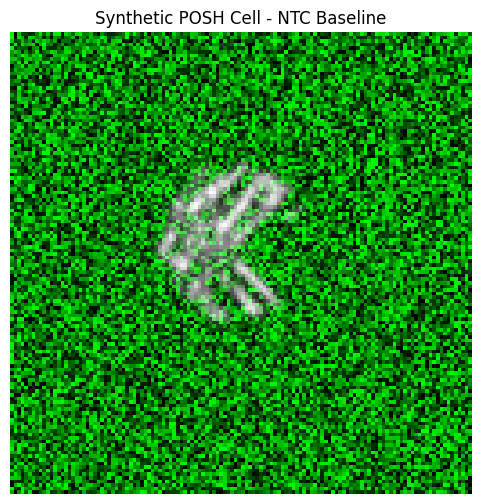


Generating KO Cell Image (Modeled Shift):


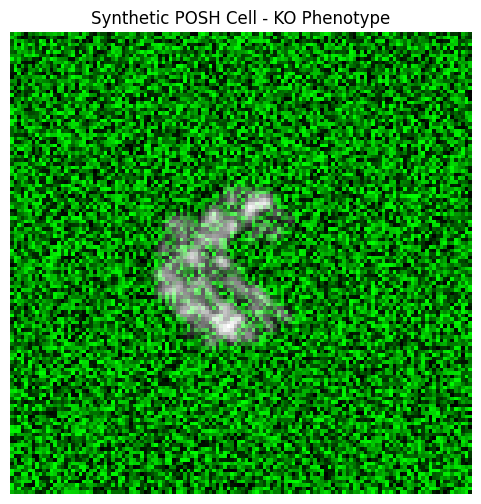

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import draw # For complex shapes
from typing import Dict, Tuple, List, Union

# Define the 5 channels used in the POSH panel
IF_CHANNELS = ["Nuclear_Stain", "ER_ConA", "Golgi_WGA", "Actin_Phalloidin", "Mito_Probe"]
N_CHANNELS = len(IF_CHANNELS)

# --- DINO and Statistical Model Parameters ---
MU_I_NTC = np.array([1000, 500, 800, 600, 950])
SIGMA_I_NTC = np.diag([200**2, 100**2, 150**2, 120**2, 180**2])
MU_I_KO = np.array([850, 600, 800, 800, 950]) # Modeled phenotypic shift
SIGMA_I_KO = 1.5 * SIGMA_I_NTC 

np.random.seed(43) 
FEATURE_MATRIX_A = np.random.randn(N_CHANNELS, N_CHANNELS) * 0.5 

EMBEDDING_DIM = 128
np.random.seed(42) 
DINO_ENCODER_W = np.random.randn(EMBEDDING_DIM, N_CHANNELS) * 0.1
DINO_ENCODER_B = np.random.randn(EMBEDDING_DIM) * 0.01

def DINO_ENCODER_F(raw_features: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Simulates the DINO non-linear transformation: W * tanh(X) + b"""
    tanh_X = np.tanh(raw_features)
    return tanh_X @ W.T + b


# ====================================================================================
# PoshAnalysisSimulator Class (Core Data Logic) - No changes here
# ====================================================================================
class PoshAnalysisSimulator:
    
    def __init__(self, embedding_dim: int = EMBEDDING_DIM):
        self.embedding_dim = embedding_dim
        self.if_dim = N_CHANNELS
        self.mu_i_ntc = MU_I_NTC
        self.sigma_i_ntc = SIGMA_I_NTC
        self.mu_i_ko = MU_I_KO
        self.sigma_i_ko = SIGMA_I_KO
        self.feature_matrix_A = FEATURE_MATRIX_A
        self.raw_feature_dim = self.feature_matrix_A.shape[0]
        self.W = DINO_ENCODER_W
        self.b = DINO_ENCODER_B

    def simulate_if_intensity_by_well(self, n_wells_ntc: int = 10, n_wells_ko: int = 10, n_cells_per_well: int = 250) -> pd.DataFrame:
        print(f"-> Simulating IF data for {n_wells_ntc} NTC and {n_wells_ko} KO wells...")
        all_data = []
        for i in range(n_wells_ntc):
            I_NTC_well = np.random.multivariate_normal(mean=self.mu_i_ntc, cov=self.sigma_i_ntc, size=n_cells_per_well)
            df_well = pd.DataFrame(I_NTC_well, columns=[f"Intensity_{ch}" for ch in IF_CHANNELS])
            df_well['Condition'], df_well['Well'] = 'NTC', f"A{i+1:02d}"
            all_data.append(df_well)
        for i in range(n_wells_ko):
            I_KO_well = np.random.multivariate_normal(mean=self.mu_i_ko, cov=self.sigma_i_ko, size=n_cells_per_well)
            df_well = pd.DataFrame(I_KO_well, columns=[f"Intensity_{ch}" for ch in IF_CHANNELS])
            df_well['Condition'], df_well['Well'] = 'KO', f"B{i+1:02d}"
            all_data.append(df_well)
        df_final = pd.concat(all_data, ignore_index=True)
        intensity_cols = [f"Intensity_{ch}" for ch in IF_CHANNELS]
        df_final[intensity_cols] = df_final[intensity_cols].clip(lower=1)
        print(f"-> Generated {len(df_final)} single-cell IF records.")
        return df_final

    def extract_features(self, I_NTC: np.ndarray, I_KO: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        X_NTC = np.log(I_NTC) @ self.feature_matrix_A.T 
        X_KO = np.log(I_KO) @ self.feature_matrix_A.T
        return X_NTC, X_KO

    def generate_embeddings(self, X_NTC: np.ndarray, X_KO: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        E_NTC = DINO_ENCODER_F(X_NTC, self.W, self.b)
        E_KO = DINO_ENCODER_F(X_KO, self.W, self.b)
        return E_NTC, E_KO

    def infer_phenotype_shift(self, E_NTC: np.ndarray, E_KO: np.ndarray) -> Dict[str, Union[float, np.ndarray]]:
        N_NTC, _ = E_NTC.shape
        N_KO, _ = E_KO.shape
        c_ntc = np.mean(E_NTC, axis=0)
        c_ko = np.mean(E_KO, axis=0)
        delta_e = c_ko - c_ntc
        S_NTC = np.cov(E_NTC, rowvar=False)
        S_KO = np.cov(E_KO, rowvar=False)
        S_pooled = ( (N_NTC - 1) * S_NTC + (N_KO - 1) * S_KO ) / (N_NTC + N_KO - 2)
        try:
            S_pooled_inv_dot_delta_e = np.linalg.solve(S_pooled, delta_e)
            D_M = np.sqrt(delta_e.T @ S_pooled_inv_dot_delta_e)
        except np.linalg.LinAlgError:
            D_M = np.nan
        results = {"delta_e_magnitude": np.linalg.norm(delta_e), "D_M": D_M}
        return results

# ====================================================================================


# ====================================================================================
# Realistic Image Generation and Visualization Functions (EXACTLY as requested)
# ====================================================================================

def generate_realistic_cell_image(size: int = 128, 
                                  intensities: Dict[str, float] = None) -> Dict[str, np.ndarray]:
    """
    Generates a realistic 128x128 pixel image of a single cell, 
    with refined WGA boundary and minimal background noise.
    """
    if intensities is None:
        intensities = {
            'Nuclear_Stain': 1.0, 'ER_ConA': 0.8, 'Golgi_WGA': 0.9, 
            'Actin_Phalloidin': 0.7, 'Mito_Probe': 0.6
        }
        
    channels = {name: np.zeros((size, size), dtype=np.float32) for name in intensities.keys()}

    center_x, center_y = size // 2, size // 2
    
    # --- 1. Define Morphology (Irregular Shapes) ---
    rr, cc, val = draw.circle_perimeter_aa(center_y, center_x, int(size * 0.4)) 
    cell_perimeter = np.vstack([rr, cc]).T
    
    perturbation_strength = int(size * 0.05)
    perturbed_perimeter = cell_perimeter + np.random.randint(-perturbation_strength, perturbation_strength, cell_perimeter.shape)
    perturbed_perimeter = np.clip(perturbed_perimeter, 0, size - 1)
    
    rr_cell, cc_cell = draw.polygon(perturbed_perimeter[:, 0], perturbed_perimeter[:, 1], shape=(size, size))
    cell_mask = np.zeros((size, size), dtype=bool)
    cell_mask[rr_cell, cc_cell] = True

    nucleus_center_y = center_y + np.random.randint(-int(size*0.05), int(size*0.05))
    nucleus_center_x = center_x + np.random.randint(-int(size*0.05), int(size*0.05))
    
    rr_nuc, cc_nuc, val_nuc = draw.circle_perimeter_aa(nucleus_center_y, nucleus_center_x, int(size * 0.15)) 
    nuc_perimeter = np.vstack([rr_nuc, cc_nuc]).T
    perturbed_nuc_perimeter = nuc_perimeter + np.random.randint(-int(size*0.03), int(size*0.03), nuc_perimeter.shape)
    perturbed_nuc_perimeter = np.clip(perturbed_nuc_perimeter, 0, size - 1)
    
    rr_nuc_fill, cc_nuc_fill = draw.polygon(perturbed_nuc_perimeter[:, 0], perturbed_nuc_perimeter[:, 1], shape=(size, size))
    nucleus_mask = np.zeros((size, size), dtype=bool)
    nucleus_mask[rr_nuc_fill, cc_nuc_fill] = True
    nucleus_mask = nucleus_mask & cell_mask # Ensure nucleus is within cell
    
    # --- 2. Populate Only Requested Channels with Intensities and Structure ---

    # Nucleus Channel (DAPI)
    I_nuc = intensities['Nuclear_Stain']
    channels['Nuclear_Stain'][nucleus_mask] = I_nuc * (0.8 + 0.2 * np.random.rand(nucleus_mask.sum())) # Strong, internal variability
    channels['Nuclear_Stain'] = gaussian_filter(channels['Nuclear_Stain'], sigma=1)
    
    # WGA Channel (Golgi/Membrane) - Explicitly create a clear boundary
    I_wga = intensities['Golgi_WGA']
    # Create a distinct ring for the membrane, slightly inside the cell_mask edge
    membrane_ring = cell_mask & ~gaussian_filter(cell_mask.astype(float), sigma=2).astype(bool)
    channels['Golgi_WGA'][membrane_ring] = I_wga * (0.9 + 0.1 * np.random.rand(membrane_ring.sum())) # Strong boundary intensity
    channels['Golgi_WGA'] = gaussian_filter(channels['Golgi_WGA'], sigma=1) # Smooth the boundary

    # Other channels are generated but will be ignored by the plotting function for now.
    # This keeps the underlying data model consistent.
    perinuclear_mask = cell_mask & ~nucleus_mask
    dist_from_nucleus_edge = gaussian_filter(nucleus_mask.astype(float), sigma=5)

    I_act = intensities['Actin_Phalloidin']
    channels['Actin_Phalloidin'][cell_mask] = I_act * (0.3 + 0.7 * np.random.rand(cell_mask.sum())) 
    channels['Actin_Phalloidin'] = gaussian_filter(channels['Actin_Phalloidin'], sigma=0.5)

    I_er = intensities['ER_ConA']
    channels['ER_ConA'][perinuclear_mask] = I_er * (0.2 + 0.8 * gaussian_filter(np.random.rand(size, size), sigma=2)[perinuclear_mask])
    channels['ER_ConA'] = gaussian_filter(channels['ER_ConA'], sigma=1.5)
    
    I_mito = intensities['Mito_Probe']
    mito_dots_mask = np.random.rand(size, size) < 0.015
    channels['Mito_Probe'][mito_dots_mask & perinuclear_mask] = I_mito
    channels['Mito_Probe'] = gaussian_filter(channels['Mito_Probe'], sigma=1)
    
    # --- 3. Final Normalization and MINIMAL Background Noise ---
    # Only add very faint, barely perceptible background noise to avoid the "full green screen"
    background_noise = np.random.rand(size, size) * 0.005 # Greatly reduced

    for name, img in channels.items():
        img += background_noise
        channels[name] = np.clip(img / img.max(), 0, 1) # Normalize each channel individually

    return channels


def plot_five_channel_composite(cell_channels: Dict[str, np.ndarray], title: str):
    """
    Displays a composite image with ONLY a white nucleus and a green WGA boundary,
    ensuring a black background and high contrast, exactly as requested.
    """
    size = cell_channels['Nuclear_Stain'].shape[0]
    composite_image = np.zeros((size, size, 3), dtype=np.float32) # Start with a black canvas

    # 1. Add Nucleus as PURE WHITE
    nucleus_img = cell_channels['Nuclear_Stain']
    # Add nucleus intensity to all three RGB channels
    composite_image[:, :, 0] += nucleus_img # Red
    composite_image[:, :, 1] += nucleus_img # Green
    composite_image[:, :, 2] += nucleus_img # Blue

    # 2. Add WGA as PURE GREEN Boundary
    wga_img = cell_channels['Golgi_WGA']
    # Add WGA intensity ONLY to the green channel.
    # Use np.maximum to ensure green is visible without totally washing out the white nucleus where they might overlap slightly.
    composite_image[:, :, 1] = np.maximum(composite_image[:, :, 1], wga_img)
    
    # 3. Final normalization and display (ensure values are within 0-1 range)
    composite_image = np.clip(composite_image, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(composite_image)
    plt.title(title, fontsize=12)
    plt.axis('off')
    plt.show()


# ====================================================================================
# EXECUTION AND COMPARISON
# ====================================================================================
if __name__ == '__main__':
    # --- 1. Run Full Simulation Pipeline to get Mean Intensities ---
    simulator = PoshAnalysisSimulator(embedding_dim=128)
    df_I = simulator.simulate_if_intensity_by_well(n_wells_ntc=10, n_wells_ko=10, n_cells_per_well=250)

    # Calculate the mean intensity vectors from the simulated data (Normalized for image function)
    mean_ntc_intensity = df_I[df_I['Condition'] == 'NTC'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].mean().values / 1000.0
    mean_ko_intensity = df_I[df_I['Condition'] == 'KO'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].mean().values / 1000.0

    ntc_intensities = dict(zip(IF_CHANNELS, mean_ntc_intensity))
    ko_intensities = dict(zip(IF_CHANNELS, mean_ko_intensity))


    # --- 2. Generate and Compare Realistic Images (NTC and KO) ---

    print("\nGenerating NTC Cell Image (White Nucleus, Green WGA Boundary):")
    ntc_channels = generate_realistic_cell_image(size=128, intensities=ntc_intensities)
    plot_five_channel_composite(ntc_channels, 'Synthetic POSH Cell - NTC Baseline')
    
    print("\nGenerating KO Cell Image (Modeled Shift):")
    ko_channels = generate_realistic_cell_image(size=128, intensities=ko_intensities)
    plot_five_channel_composite(ko_channels, 'Synthetic POSH Cell - KO Phenotype')
    
    # Optional: You can re-run the D_M calculation here if needed
    # I_NTC = df_I[df_I['Condition'] == 'NTC'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].values
    # I_KO = df_I[df_I['Condition'] == 'KO'][[f"Intensity_{ch}" for ch in IF_CHANNELS]].values
    # X_NTC, X_KO = simulator.extract_features(I_NTC, I_KO) 
    # E_NTC, E_KO = simulator.generate_embeddings(X_NTC, X_KO)
    # analysis_results = simulator.infer_phenotype_shift(E_NTC, E_KO)
    # print(f"\nMahalanobis D_M for Simulated Shift: {analysis_results['D_M']:.4f}")